# Set up

Create a regression problem

In [1]:
import pandas as pd
import numpy as np

from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score

%matplotlib inline

In [2]:
X, y = make_regression(n_samples=1000)

Use a Random Forest to model the problem

In [3]:
model = RandomForestRegressor(oob_score=True, n_estimators=100, n_jobs=-1)

In [4]:
model.fit(X, y)
model.oob_score_

0.75872516794413636

In [5]:
y_hat = model.oob_prediction_

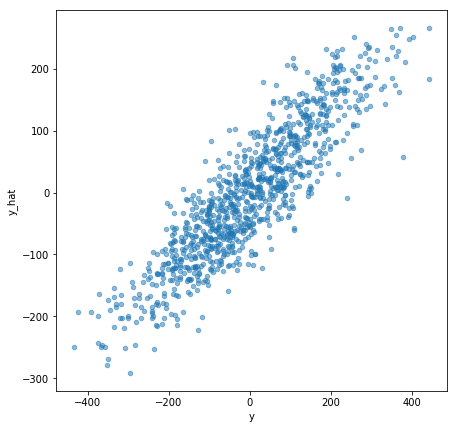

In [6]:
df = pd.DataFrame({
    'y': y,
    'y_hat': y_hat
})

df = df.sort_values(by='y')

df.plot('y', 'y_hat', kind='scatter', alpha=0.5, figsize=(7, 7))

# Use the Transformer to calibrate

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin

# Hacky way to change a RandomForest into a Transformer
class RandomForestTransformer(RandomForestRegressor, TransformerMixin):
    
    def transform(self, X, y=None):
        return self.predict(X)

In [74]:
rf = RandomForestTransformer(oob_score=True, n_estimators=100)
qc = QuantileCalibrator(quantile=100, isotonic_fit=True, isotonic_lambda=1)

steps = [
    ('random_forest', rf),
    ('quantile_cal', qc)
]

pipeline = Pipeline(steps=steps)

In [75]:
pipeline.fit(X, y)

Pipeline(memory=None,
     steps=[('random_forest', RandomForestTransformer(bootstrap=True, criterion='mse', max_depth=None,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction...t=False)), ('quantile_cal', QuantileCalibrator(isotonic_fit=True, isotonic_lambda=1, quantile=100))])

Scoring like this will result in over fitting:

In [76]:
pipeline.score(X, y)

0.97930957786226502

We can instead use the out-of-bag predictions:

In [77]:
qc.score(rf.oob_prediction_, y)

0.77187461116332878

# Cross Validate Results

Alternatively, we can use $k$-fold cross validation on the entire pipeline

In [78]:
from sklearn.model_selection import cross_validate, cross_val_score

In [80]:
cross_validated_scores = pd.Series(cross_val_score(X=X, y=y, cv=10, estimator=pipeline))
cross_validated_scores.describe()

count    10.000000
mean      0.783342
std       0.027032
min       0.736359
25%       0.764073
50%       0.782925
75%       0.806722
max       0.814103
dtype: float64

# Hyper Parameter Search

We can now optimize to find the best hyper parameters.

First, we'll do this with only the Random Forest.

In [93]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

In [100]:
search_params = {
    'n_estimators': randint(10, 1000),
    'max_features': uniform(0, 1)
}

rf = RandomForestRegressor()

random_search = RandomizedSearchCV(estimator=rf, param_distributions=search_params, n_iter=30, n_jobs=-1)

In [101]:
search_result = random_search.fit(X, y)

In [107]:
# Train on the full dataset
rf.set_params(oob_score=True, **search_result.best_params_)
rf.fit(X, y)
rf.oob_score_

0.76619069461106581

Next, we can fit a quantile calibrator using these parameters!

In [111]:
rf = RandomForestTransformer(**search_result.best_params_)
qc = QuantileCalibrator()

pipeline = Pipeline(steps=[
    ('random_forest', rf),
    ('quantile_calibrator', qc)
])

# We only need to fit params for the QuantileCalibrator because the RandomForest was already fit above.
search_params = {
    'quantile_calibrator__quantile': randint(10, 1000),
    'quantile_calibrator__isotonic_fit': [True, False],
    'quantile_calibrator__isotonic_lambda': uniform(0.01, 20)
}

random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=search_params, n_iter=30, n_jobs=-1)

In [112]:
search_result2 = random_search.fit(X, y)

JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/usr/lib/python3.5/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    179         sys.exit(msg)
    180     main_globals = sys.modules["__main__"].__dict__
    181     if alter_argv:
    182         sys.argv[0] = mod_spec.origin
    183     return _run_code(code, main_globals, None,
--> 184                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.5/dist-packages/ipykernel_launcher.py')
    185 
    186 def run_module(mod_name, init_globals=None,
    187                run_name=None, alter_sys=False):
    188     """Execute a module's code without importing it

...........................................................................
/usr/lib/python3.5/runpy.py in _run_code(code=<code object <module> at 0x7fe8e46b7a50, file "/...3.5/dist-packages/ipykernel_launcher.py", line 5>, run_globals={'__builtins__': <module 'builtins' (built-in)>, '__cached__': '/usr/local/lib/python3.5/dist-packages/__pycache__/ipykernel_launcher.cpython-35.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.5/dist-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py'>, 'sys': <module 'sys' (built-in)>}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.5/dist-packages/ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x7fe8e46b7a50, file "/...3.5/dist-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__builtins__': <module 'builtins' (built-in)>, '__cached__': '/usr/local/lib/python3.5/dist-packages/__pycache__/ipykernel_launcher.cpython-35.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.5/dist-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py'>, 'sys': <module 'sys' (built-in)>}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    472             return self.subapp.start()
    473         if self.poller is not None:
    474             self.poller.start()
    475         self.kernel.start()
    476         try:
--> 477             ioloop.IOLoop.instance().start()
    478         except KeyboardInterrupt:
    479             pass
    480 
    481 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/usr/local/lib/python3.5/dist-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
/usr/local/lib/python3.5/dist-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    883                 self._events.update(event_pairs)
    884                 while self._events:
    885                     fd, events = self._events.popitem()
    886                     try:
    887                         fd_obj, handler_func = self._handlers[fd]
--> 888                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    889                     except (OSError, IOError) as e:
    890                         if errno_from_exception(e) == errno.EPIPE:
    891                             # Happens when the client closes the connection
    892                             pass

...........................................................................
/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': 'search_result2 = random_search.fit(X, y)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 4, 21, 17, 22, 49, 262968, tzinfo=tzutc()), 'msg_id': 'D4CFA9CD8FEC42AFA71BADD1695AEFC4', 'msg_type': 'execute_request', 'session': 'D8C479C77BAD40208A4267BBA3AAA552', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'D4CFA9CD8FEC42AFA71BADD1695AEFC4', 'msg_type': 'execute_request', 'parent_header': {}})
    230             self.log.warn("Unknown message type: %r", msg_type)
    231         else:
    232             self.log.debug("%s: %s", msg_type, msg)
    233             self.pre_handler_hook()
    234             try:
--> 235                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'D8C479C77BAD40208A4267BBA3AAA552']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': 'search_result2 = random_search.fit(X, y)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 4, 21, 17, 22, 49, 262968, tzinfo=tzutc()), 'msg_id': 'D4CFA9CD8FEC42AFA71BADD1695AEFC4', 'msg_type': 'execute_request', 'session': 'D8C479C77BAD40208A4267BBA3AAA552', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'D4CFA9CD8FEC42AFA71BADD1695AEFC4', 'msg_type': 'execute_request', 'parent_header': {}}
    236             except Exception:
    237                 self.log.error("Exception in message handler:", exc_info=True)
    238             finally:
    239                 self.post_handler_hook()

...........................................................................
/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'D8C479C77BAD40208A4267BBA3AAA552'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': 'search_result2 = random_search.fit(X, y)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 4, 21, 17, 22, 49, 262968, tzinfo=tzutc()), 'msg_id': 'D4CFA9CD8FEC42AFA71BADD1695AEFC4', 'msg_type': 'execute_request', 'session': 'D8C479C77BAD40208A4267BBA3AAA552', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'D4CFA9CD8FEC42AFA71BADD1695AEFC4', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/usr/local/lib/python3.5/dist-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='search_result2 = random_search.fit(X, y)', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    191 
    192         self._forward_input(allow_stdin)
    193 
    194         reply_content = {}
    195         try:
--> 196             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = 'search_result2 = random_search.fit(X, y)'
        store_history = True
        silent = False
    197         finally:
    198             self._restore_input()
    199 
    200         if res.error_before_exec is not None:

...........................................................................
/usr/local/lib/python3.5/dist-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('search_result2 = random_search.fit(X, y)',), **kwargs={'silent': False, 'store_history': True})
    528             )
    529         self.payload_manager.write_payload(payload)
    530 
    531     def run_cell(self, *args, **kwargs):
    532         self._last_traceback = None
--> 533         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('search_result2 = random_search.fit(X, y)',)
        kwargs = {'silent': False, 'store_history': True}
    534 
    535     def _showtraceback(self, etype, evalue, stb):
    536         # try to preserve ordering of tracebacks and print statements
    537         sys.stdout.flush()

...........................................................................
/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='search_result2 = random_search.fit(X, y)', store_history=True, silent=False, shell_futures=True)
   2723                 self.displayhook.exec_result = result
   2724 
   2725                 # Execute the user code
   2726                 interactivity = "none" if silent else self.ast_node_interactivity
   2727                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2728                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2729                 
   2730                 self.last_execution_succeeded = not has_raised
   2731                 self.last_execution_result = result
   2732 

...........................................................................
/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Assign object>], cell_name='<ipython-input-112-631dd26a40b3>', interactivity='none', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 7fe895c80e10, executi..._before_exec=None error_in_exec=None result=None>)
   2845 
   2846         try:
   2847             for i, node in enumerate(to_run_exec):
   2848                 mod = ast.Module([node])
   2849                 code = compiler(mod, cell_name, "exec")
-> 2850                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x7fe89580ee40, file "<ipython-input-112-631dd26a40b3>", line 1>
        result = <ExecutionResult object at 7fe895c80e10, executi..._before_exec=None error_in_exec=None result=None>
   2851                     return True
   2852 
   2853             for i, node in enumerate(to_run_interactive):
   2854                 mod = ast.Interactive([node])

...........................................................................
/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x7fe89580ee40, file "<ipython-input-112-631dd26a40b3>", line 1>, result=<ExecutionResult object at 7fe895c80e10, executi..._before_exec=None error_in_exec=None result=None>)
   2905         outflag = True  # happens in more places, so it's easier as default
   2906         try:
   2907             try:
   2908                 self.hooks.pre_run_code_hook()
   2909                 #rprint('Running code', repr(code_obj)) # dbg
-> 2910                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x7fe89580ee40, file "<ipython-input-112-631dd26a40b3>", line 1>
        self.user_global_ns = {'In': ['', "import pandas as pd\nimport numpy as np\n\nfrom skl..._ipython().run_line_magic('matplotlib', 'inline')", 'X, y = make_regression(n_samples=1000)', 'model = RandomForestRegressor(oob_score=True, n_estimators=100, n_jobs=-1)', 'model.fit(X, y)\nmodel.oob_score_', 'y_hat = model.oob_prediction_', "df = pd.DataFrame({\n    'y': y,\n    'y_hat': y_h..._hat', kind='scatter', alpha=0.5, figsize=(7, 7))", 'from QuantileCalibrator import QuantileCalibrator', 'qc = QuantileCalibrator(quantile=100, isotonic_fit=True, isotonic_lambda=0)', 'qc.fit(y_hat, y)', "df['y_hat2'] = qc.transform(df['y_hat'])", "df.plot('y', 'y_hat2', kind='scatter', alpha=0.5, figsize=(7, 7))", 'r2_score(y, qc.transform(y_hat))', 'qc = QuantileCalibrator(quantile=100, isotonic_fit=True, isotonic_lambda=1)', 'qc.fit(y_hat, y)', "df['y_hat2'] = qc.transform(df['y_hat'])", "df.plot('y', 'y_hat2', kind='scatter', alpha=0.5, figsize=(7, 7))", 'r2_score(y, qc.transform(y_hat))', 'from sklearn.pipeline import Pipeline\n\nfrom skle...(self, X, y=None):\n        return self.predict(X)', 'from sklearn.pipeline import Pipeline\nfrom sklea...(self, X, y=None):\n        return self.predict(X)', ...], 'Out': {4: 0.75872516794413636, 6: <matplotlib.axes._subplots.AxesSubplot object>, 9: QuantileCalibrator(isotonic_fit=True, isotonic_lambda=0, quantile=100), 11: <matplotlib.axes._subplots.AxesSubplot object>, 12: 0.80235461398325469, 14: QuantileCalibrator(isotonic_fit=True, isotonic_lambda=1, quantile=100), 16: <matplotlib.axes._subplots.AxesSubplot object>, 17: 0.79904022278519515, 22: Pipeline(memory=None,
     steps=[('random_fores...onic_fit=True, isotonic_lambda=1, quantile=10))]), 27: Pipeline(memory=None,
     steps=[('random_fores...onic_fit=True, isotonic_lambda=1, quantile=10))]), ...}, 'Pipeline': <class 'sklearn.pipeline.Pipeline'>, 'QuantileCalibrator': <class 'QuantileCalibrator.QuantileCalibrator'>, 'RandomForestRegressor': <class 'sklearn.ensemble.forest.RandomForestRegressor'>, 'RandomForestTransformer': <class '__main__.RandomForestTransformer'>, 'RandomizedSearchCV': <class 'sklearn.model_selection._search.RandomizedSearchCV'>, 'TransformerMixin': <class 'sklearn.base.TransformerMixin'>, 'X': array([[  5.07526289e-02,   9.85078776e-01,   4....702260e+00,  -1.37758700e+00,  -9.69520069e-01]]), '_': 0.76619069461106581, ...}
        self.user_ns = {'In': ['', "import pandas as pd\nimport numpy as np\n\nfrom skl..._ipython().run_line_magic('matplotlib', 'inline')", 'X, y = make_regression(n_samples=1000)', 'model = RandomForestRegressor(oob_score=True, n_estimators=100, n_jobs=-1)', 'model.fit(X, y)\nmodel.oob_score_', 'y_hat = model.oob_prediction_', "df = pd.DataFrame({\n    'y': y,\n    'y_hat': y_h..._hat', kind='scatter', alpha=0.5, figsize=(7, 7))", 'from QuantileCalibrator import QuantileCalibrator', 'qc = QuantileCalibrator(quantile=100, isotonic_fit=True, isotonic_lambda=0)', 'qc.fit(y_hat, y)', "df['y_hat2'] = qc.transform(df['y_hat'])", "df.plot('y', 'y_hat2', kind='scatter', alpha=0.5, figsize=(7, 7))", 'r2_score(y, qc.transform(y_hat))', 'qc = QuantileCalibrator(quantile=100, isotonic_fit=True, isotonic_lambda=1)', 'qc.fit(y_hat, y)', "df['y_hat2'] = qc.transform(df['y_hat'])", "df.plot('y', 'y_hat2', kind='scatter', alpha=0.5, figsize=(7, 7))", 'r2_score(y, qc.transform(y_hat))', 'from sklearn.pipeline import Pipeline\n\nfrom skle...(self, X, y=None):\n        return self.predict(X)', 'from sklearn.pipeline import Pipeline\nfrom sklea...(self, X, y=None):\n        return self.predict(X)', ...], 'Out': {4: 0.75872516794413636, 6: <matplotlib.axes._subplots.AxesSubplot object>, 9: QuantileCalibrator(isotonic_fit=True, isotonic_lambda=0, quantile=100), 11: <matplotlib.axes._subplots.AxesSubplot object>, 12: 0.80235461398325469, 14: QuantileCalibrator(isotonic_fit=True, isotonic_lambda=1, quantile=100), 16: <matplotlib.axes._subplots.AxesSubplot object>, 17: 0.79904022278519515, 22: Pipeline(memory=None,
     steps=[('random_fores...onic_fit=True, isotonic_lambda=1, quantile=10))]), 27: Pipeline(memory=None,
     steps=[('random_fores...onic_fit=True, isotonic_lambda=1, quantile=10))]), ...}, 'Pipeline': <class 'sklearn.pipeline.Pipeline'>, 'QuantileCalibrator': <class 'QuantileCalibrator.QuantileCalibrator'>, 'RandomForestRegressor': <class 'sklearn.ensemble.forest.RandomForestRegressor'>, 'RandomForestTransformer': <class '__main__.RandomForestTransformer'>, 'RandomizedSearchCV': <class 'sklearn.model_selection._search.RandomizedSearchCV'>, 'TransformerMixin': <class 'sklearn.base.TransformerMixin'>, 'X': array([[  5.07526289e-02,   9.85078776e-01,   4....702260e+00,  -1.37758700e+00,  -9.69520069e-01]]), '_': 0.76619069461106581, ...}
   2911             finally:
   2912                 # Reset our crash handler in place
   2913                 sys.excepthook = old_excepthook
   2914         except SystemExit as e:

...........................................................................
/home/david/quantile-calibration/<ipython-input-112-631dd26a40b3> in <module>()
----> 1 search_result2 = random_search.fit(X, y)

...........................................................................
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_search.py in fit(self=RandomizedSearchCV(cv=None, error_score='raise',...turn_train_score='warn', scoring=None, verbose=0), X=array([[  5.07526289e-02,   9.85078776e-01,   4....702260e+00,  -1.37758700e+00,  -9.69520069e-01]]), y=array([ -6.58272648e+01,  -1.04739053e+02,  -2.7...e+01,   1.19872551e+02,
        -3.91969121e+00]), groups=None, **fit_params={})
    634                                   return_train_score=self.return_train_score,
    635                                   return_n_test_samples=True,
    636                                   return_times=True, return_parameters=False,
    637                                   error_score=self.error_score)
    638           for parameters, (train, test) in product(candidate_params,
--> 639                                                    cv.split(X, y, groups)))
        cv.split = <bound method _BaseKFold.split of KFold(n_splits=3, random_state=None, shuffle=False)>
        X = array([[  5.07526289e-02,   9.85078776e-01,   4....702260e+00,  -1.37758700e+00,  -9.69520069e-01]])
        y = array([ -6.58272648e+01,  -1.04739053e+02,  -2.7...e+01,   1.19872551e+02,
        -3.91969121e+00])
        groups = None
    640 
    641         # if one choose to see train score, "out" will contain train score info
    642         if self.return_train_score:
    643             (train_score_dicts, test_score_dicts, test_sample_counts, fit_time,

...........................................................................
/usr/local/lib/python3.5/dist-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object BaseSearchCV.fit.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Sat Apr 21 13:24:41 2018
PID: 9478                                    Python 3.5.2: /usr/bin/python3
...........................................................................
/usr/local/lib/python3.5/dist-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (Pipeline(memory=None,
     steps=[('random_fores...da=14.672207757591393,
          quantile=895))]), array([[  5.07526289e-02,   9.85078776e-01,   4....702260e+00,  -1.37758700e+00,  -9.69520069e-01]]), array([ -6.58272648e+01,  -1.04739053e+02,  -2.7...e+01,   1.19872551e+02,
        -3.91969121e+00]), {'score': <function _passthrough_scorer>}, array([334, 335, 336, 337, 338, 339, 340, 341, 3..., 992, 993, 994, 995, 996,
       997, 998, 999]), array([  0,   1,   2,   3,   4,   5,   6,   7,  ...    325, 326, 327, 328, 329, 330, 331, 332, 333]), 0, {'quantile_calibrator__isotonic_fit': False, 'quantile_calibrator__isotonic_lambda': 14.672207757591393, 'quantile_calibrator__quantile': 895}), {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/usr/local/lib/python3.5/dist-packages/sklearn/externals/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (Pipeline(memory=None,
     steps=[('random_fores...da=14.672207757591393,
          quantile=895))]), array([[  5.07526289e-02,   9.85078776e-01,   4....702260e+00,  -1.37758700e+00,  -9.69520069e-01]]), array([ -6.58272648e+01,  -1.04739053e+02,  -2.7...e+01,   1.19872551e+02,
        -3.91969121e+00]), {'score': <function _passthrough_scorer>}, array([334, 335, 336, 337, 338, 339, 340, 341, 3..., 992, 993, 994, 995, 996,
       997, 998, 999]), array([  0,   1,   2,   3,   4,   5,   6,   7,  ...    325, 326, 327, 328, 329, 330, 331, 332, 333]), 0, {'quantile_calibrator__isotonic_fit': False, 'quantile_calibrator__isotonic_lambda': 14.672207757591393, 'quantile_calibrator__quantile': 895})
        kwargs = {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_validation.py in _fit_and_score(estimator=Pipeline(memory=None,
     steps=[('random_fores...da=14.672207757591393,
          quantile=895))]), X=array([[  5.07526289e-02,   9.85078776e-01,   4....702260e+00,  -1.37758700e+00,  -9.69520069e-01]]), y=array([ -6.58272648e+01,  -1.04739053e+02,  -2.7...e+01,   1.19872551e+02,
        -3.91969121e+00]), scorer={'score': <function _passthrough_scorer>}, train=array([334, 335, 336, 337, 338, 339, 340, 341, 3..., 992, 993, 994, 995, 996,
       997, 998, 999]), test=array([  0,   1,   2,   3,   4,   5,   6,   7,  ...    325, 326, 327, 328, 329, 330, 331, 332, 333]), verbose=0, parameters={'quantile_calibrator__isotonic_fit': False, 'quantile_calibrator__isotonic_lambda': 14.672207757591393, 'quantile_calibrator__quantile': 895}, fit_params={}, return_train_score='warn', return_parameters=False, return_n_test_samples=True, return_times=True, error_score='raise')
    483                              " make sure that it has been spelled correctly.)")
    484 
    485     else:
    486         fit_time = time.time() - start_time
    487         # _score will return dict if is_multimetric is True
--> 488         test_scores = _score(estimator, X_test, y_test, scorer, is_multimetric)
        test_scores = {}
        estimator = Pipeline(memory=None,
     steps=[('random_fores...da=14.672207757591393,
          quantile=895))])
        X_test = array([[  5.07526289e-02,   9.85078776e-01,   4....473925e+00,   7.18220022e-01,  -1.15602586e+00]])
        y_test = array([ -65.82726481, -104.73905265,  -27.054767...3.12306514,
         17.31028004,  148.56162263])
        scorer = {'score': <function _passthrough_scorer>}
        is_multimetric = True
    489         score_time = time.time() - start_time - fit_time
    490         if return_train_score:
    491             train_scores = _score(estimator, X_train, y_train, scorer,
    492                                   is_multimetric)

...........................................................................
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_validation.py in _score(estimator=Pipeline(memory=None,
     steps=[('random_fores...da=14.672207757591393,
          quantile=895))]), X_test=array([[  5.07526289e-02,   9.85078776e-01,   4....473925e+00,   7.18220022e-01,  -1.15602586e+00]]), y_test=array([ -65.82726481, -104.73905265,  -27.054767...3.12306514,
         17.31028004,  148.56162263]), scorer={'score': <function _passthrough_scorer>}, is_multimetric=True)
    518 
    519     Will return a single float if is_multimetric is False and a dict of floats,
    520     if is_multimetric is True
    521     """
    522     if is_multimetric:
--> 523         return _multimetric_score(estimator, X_test, y_test, scorer)
        estimator = Pipeline(memory=None,
     steps=[('random_fores...da=14.672207757591393,
          quantile=895))])
        X_test = array([[  5.07526289e-02,   9.85078776e-01,   4....473925e+00,   7.18220022e-01,  -1.15602586e+00]])
        y_test = array([ -65.82726481, -104.73905265,  -27.054767...3.12306514,
         17.31028004,  148.56162263])
        scorer = {'score': <function _passthrough_scorer>}
    524     else:
    525         if y_test is None:
    526             score = scorer(estimator, X_test)
    527         else:

...........................................................................
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_validation.py in _multimetric_score(estimator=Pipeline(memory=None,
     steps=[('random_fores...da=14.672207757591393,
          quantile=895))]), X_test=array([[  5.07526289e-02,   9.85078776e-01,   4....473925e+00,   7.18220022e-01,  -1.15602586e+00]]), y_test=array([ -65.82726481, -104.73905265,  -27.054767...3.12306514,
         17.31028004,  148.56162263]), scorers={'score': <function _passthrough_scorer>})
    548 
    549     for name, scorer in scorers.items():
    550         if y_test is None:
    551             score = scorer(estimator, X_test)
    552         else:
--> 553             score = scorer(estimator, X_test, y_test)
        score = undefined
        scorer = <function _passthrough_scorer>
        estimator = Pipeline(memory=None,
     steps=[('random_fores...da=14.672207757591393,
          quantile=895))])
        X_test = array([[  5.07526289e-02,   9.85078776e-01,   4....473925e+00,   7.18220022e-01,  -1.15602586e+00]])
        y_test = array([ -65.82726481, -104.73905265,  -27.054767...3.12306514,
         17.31028004,  148.56162263])
    554 
    555         if hasattr(score, 'item'):
    556             try:
    557                 # e.g. unwrap memmapped scalars

...........................................................................
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/scorer.py in _passthrough_scorer(estimator=Pipeline(memory=None,
     steps=[('random_fores...da=14.672207757591393,
          quantile=895))]), *args=(array([[  5.07526289e-02,   9.85078776e-01,   4....473925e+00,   7.18220022e-01,  -1.15602586e+00]]), array([ -65.82726481, -104.73905265,  -27.054767...3.12306514,
         17.31028004,  148.56162263])), **kwargs={})
    239     return scorer
    240 
    241 
    242 def _passthrough_scorer(estimator, *args, **kwargs):
    243     """Function that wraps estimator.score"""
--> 244     return estimator.score(*args, **kwargs)
        estimator.score = <function Pipeline.score>
        args = (array([[  5.07526289e-02,   9.85078776e-01,   4....473925e+00,   7.18220022e-01,  -1.15602586e+00]]), array([ -65.82726481, -104.73905265,  -27.054767...3.12306514,
         17.31028004,  148.56162263]))
        kwargs = {}
    245 
    246 
    247 def check_scoring(estimator, scoring=None, allow_none=False):
    248     """Determine scorer from user options.

...........................................................................
/usr/local/lib/python3.5/dist-packages/sklearn/utils/metaestimators.py in <lambda>(*args=(array([[  5.07526289e-02,   9.85078776e-01,   4....473925e+00,   7.18220022e-01,  -1.15602586e+00]]), array([ -65.82726481, -104.73905265,  -27.054767...3.12306514,
         17.31028004,  148.56162263])), **kwargs={})
    110                     break
    111             else:
    112                 attrgetter(self.delegate_names[-1])(obj)
    113 
    114         # lambda, but not partial, allows help() to work with update_wrapper
--> 115         out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)
        args = (array([[  5.07526289e-02,   9.85078776e-01,   4....473925e+00,   7.18220022e-01,  -1.15602586e+00]]), array([ -65.82726481, -104.73905265,  -27.054767...3.12306514,
         17.31028004,  148.56162263]))
        kwargs = {}
    116         # update the docstring of the returned function
    117         update_wrapper(out, self.fn)
    118         return out
    119 

...........................................................................
/usr/local/lib/python3.5/dist-packages/sklearn/pipeline.py in score(self=Pipeline(memory=None,
     steps=[('random_fores...da=14.672207757591393,
          quantile=895))]), X=array([[  5.07526289e-02,   9.85078776e-01,   4....473925e+00,   7.18220022e-01,  -1.15602586e+00]]), y=array([ -65.82726481, -104.73905265,  -27.054767...3.12306514,
         17.31028004,  148.56162263]), sample_weight=None)
    485             if transform is not None:
    486                 Xt = transform.transform(Xt)
    487         score_params = {}
    488         if sample_weight is not None:
    489             score_params['sample_weight'] = sample_weight
--> 490         return self.steps[-1][-1].score(Xt, y, **score_params)
        self.steps.score = undefined
        Xt = array([  -7.0319462 ,  -29.28390736,    2.622598...7.59767751,
        -40.6328167 ,   82.77684203])
        y = array([ -65.82726481, -104.73905265,  -27.054767...3.12306514,
         17.31028004,  148.56162263])
        score_params = {}
    491 
    492     @property
    493     def classes_(self):
    494         return self.steps[-1][-1].classes_

...........................................................................
/usr/local/lib/python3.5/dist-packages/sklearn/base.py in score(self=QuantileCalibrator(isotonic_fit=False, isotonic_lambda=14.672207757591393,
          quantile=895), X=array([  -7.0319462 ,  -29.28390736,    2.622598...7.59767751,
        -40.6328167 ,   82.77684203]), y=array([ -65.82726481, -104.73905265,  -27.054767...3.12306514,
         17.31028004,  148.56162263]), sample_weight=None)
    382             R^2 of self.predict(X) wrt. y.
    383         """
    384 
    385         from .metrics import r2_score
    386         return r2_score(y, self.predict(X), sample_weight=sample_weight,
--> 387                         multioutput='variance_weighted')
    388 
    389 
    390 ###############################################################################
    391 class ClusterMixin(object):

...........................................................................
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/regression.py in r2_score(y_true=array([ -65.82726481, -104.73905265,  -27.054767...3.12306514,
         17.31028004,  148.56162263]), y_pred=array([ -2.57731691e-01,  -2.35585082e+01,      ...e+01,              nan,
                    nan]), sample_weight=None, multioutput='variance_weighted')
    525     >>> y_pred = [3,2,1]
    526     >>> r2_score(y_true, y_pred)
    527     -3.0
    528     """
    529     y_type, y_true, y_pred, multioutput = _check_reg_targets(
--> 530         y_true, y_pred, multioutput)
        y_true = array([ -65.82726481, -104.73905265,  -27.054767...3.12306514,
         17.31028004,  148.56162263])
        y_pred = array([ -2.57731691e-01,  -2.35585082e+01,      ...e+01,              nan,
                    nan])
        multioutput = 'variance_weighted'
    531 
    532     if sample_weight is not None:
    533         sample_weight = column_or_1d(sample_weight)
    534         weight = sample_weight[:, np.newaxis]

...........................................................................
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/regression.py in _check_reg_targets(y_true=array([ -65.82726481, -104.73905265,  -27.054767...3.12306514,
         17.31028004,  148.56162263]), y_pred=array([ -2.57731691e-01,  -2.35585082e+01,      ...e+01,              nan,
                    nan]), multioutput='variance_weighted')
     72         correct keyword.
     73 
     74     """
     75     check_consistent_length(y_true, y_pred)
     76     y_true = check_array(y_true, ensure_2d=False)
---> 77     y_pred = check_array(y_pred, ensure_2d=False)
        y_pred = array([ -2.57731691e-01,  -2.35585082e+01,      ...e+01,              nan,
                    nan])
     78 
     79     if y_true.ndim == 1:
     80         y_true = y_true.reshape((-1, 1))
     81 

...........................................................................
/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py in check_array(array=array([ -2.57731691e-01,  -2.35585082e+01,      ...e+01,              nan,
                    nan]), accept_sparse=False, dtype=None, order=None, copy=False, force_all_finite=True, ensure_2d=False, allow_nd=False, ensure_min_samples=1, ensure_min_features=1, warn_on_dtype=False, estimator=None)
    448             array = array.astype(np.float64)
    449         if not allow_nd and array.ndim >= 3:
    450             raise ValueError("Found array with dim %d. %s expected <= 2."
    451                              % (array.ndim, estimator_name))
    452         if force_all_finite:
--> 453             _assert_all_finite(array)
        array = array([ -2.57731691e-01,  -2.35585082e+01,      ...e+01,              nan,
                    nan])
    454 
    455     shape_repr = _shape_repr(array.shape)
    456     if ensure_min_samples > 0:
    457         n_samples = _num_samples(array)

...........................................................................
/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py in _assert_all_finite(X=array([ -2.57731691e-01,  -2.35585082e+01,      ...e+01,              nan,
                    nan]))
     39     # everything is finite; fall back to O(n) space np.isfinite to prevent
     40     # false positives from overflow in sum method.
     41     if (X.dtype.char in np.typecodes['AllFloat'] and not np.isfinite(X.sum())
     42             and not np.isfinite(X).all()):
     43         raise ValueError("Input contains NaN, infinity"
---> 44                          " or a value too large for %r." % X.dtype)
        X.dtype = dtype('float64')
     45 
     46 
     47 def assert_all_finite(X):
     48     """Throw a ValueError if X contains NaN or infinity.

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').
___________________________________________________________________________